# MSAI 495: Deep Reinforcement Learning
### Final Project
### Alec Lei, Peter Salvino, Riuze Yang, & Qiaohan Yang

Package requirements:
-datajoint (Requires Python>= 3.4)
-if data is download, please load data with pickle

In [1]:
# import pyximport
# pyximport.install()

import os
import sys
import copy
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
# import ssm
# from ssm.util import find_permutation

Server configuration: requires connection to Northwestern VPN

### Clean data

In [2]:
data_path=r'behaviordata'

with open(data_path,'rb') as f:
    data=pk.load(f)
# data#[['trial_id','task','maze_id','speed_by_cm']]

In [3]:
# remove test mice
data = data[~(data.subject_fullname.isin(["Unknown_Peter", "apr456_CR6error", "lpr6177_test1", "pss3570_TrainTest"]))]

# only keep session with final maze
data = data[data.main_maze_id == 11]

# remove trials in warmup block
data = data[data.maze_id == 11]

# re-index
data.reset_index(drop=True, inplace = True)

data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,17,11,11,R,R,...,1.20552,3.99751,4.29751,7.14768,7.15610,8.44789,NaN,1.8,1.000000,1
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,18,11,11,L,L,...,1.25294,3.86986,3.90327,6.67835,6.68664,7.98687,NaN,1.8,1.000000,0
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,19,11,11,L,L,...,1.28354,3.70875,3.70875,7.17565,7.18403,8.46765,NaN,1.8,1.000000,0
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,20,11,11,R,R,...,1.23340,3.95028,3.96694,7.61773,7.63231,8.92588,NaN,1.8,1.000000,0
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,21,11,11,L,L,...,1.62524,4.23376,4.23376,7.22577,7.23439,8.52593,NaN,1.8,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134369,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,209,11,11,R,R,...,6.02491,9.70000,9.70833,12.88370,12.89230,14.50070,NaN,3.0,0.333333,0
134370,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,210,11,11,L,R,...,2.63380,5.45876,6.50895,8.57607,NaN,9.64249,NaN,0.0,0.333333,0
134371,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,211,11,11,R,R,...,3.08150,5.95687,8.80719,9.73256,9.74058,11.34070,NaN,3.0,0.333333,0
134372,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,218,11,11,R,R,...,1.11419,3.38098,5.69792,7.87327,7.88175,9.49006,NaN,3.0,1.000000,1


In [103]:
data = copy.deepcopy(data_backup)

In [4]:
# find sessions with more than 50 trial
session = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
session_large = session[session.trial_count > 50]
session_large = session_large.drop('trial_count', 1)

# session_large

# keep only data in good sessions
data = pd.merge(data, session_large, how='outer', indicator=True)
data = data[data._merge == "both"]

data = data.drop('_merge', 1)
data.reset_index(drop=True, inplace = True)

data

/var/folders/5j/p3g0czyd4vs1d7ck9dxxhhx80000gn/T/ipykernel_77000/1987209461.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  session_large = session_large.drop('trial_count', 1)
/var/folders/5j/p3g0czyd4vs1d7ck9dxxhhx80000gn/T/ipykernel_77000/1987209461.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('_merge', 1)


,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,17,11,11,R,R,...,1.20552,3.99751,4.29751,7.14768,7.15610,8.44789,NaN,1.8,1.000000,1
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,18,11,11,L,L,...,1.25294,3.86986,3.90327,6.67835,6.68664,7.98687,NaN,1.8,1.000000,0
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,19,11,11,L,L,...,1.28354,3.70875,3.70875,7.17565,7.18403,8.46765,NaN,1.8,1.000000,0
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,20,11,11,R,R,...,1.23340,3.95028,3.96694,7.61773,7.63231,8.92588,NaN,1.8,1.000000,0
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,21,11,11,L,L,...,1.62524,4.23376,4.23376,7.22577,7.23439,8.52593,NaN,1.8,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132966,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,209,11,11,R,R,...,6.02491,9.70000,9.70833,12.88370,12.89230,14.50070,NaN,3.0,0.333333,0
132967,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,210,11,11,L,R,...,2.63380,5.45876,6.50895,8.57607,NaN,9.64249,NaN,0.0,0.333333,0
132968,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,211,11,11,R,R,...,3.08150,5.95687,8.80719,9.73256,9.74058,11.34070,NaN,3.0,0.333333,0
132969,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,218,11,11,R,R,...,1.11419,3.38098,5.69792,7.87327,7.88175,9.49006,NaN,3.0,1.000000,1


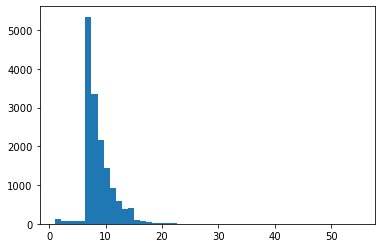

/var/folders/5j/p3g0czyd4vs1d7ck9dxxhhx80000gn/T/ipykernel_77000/2365168294.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('block_keep', 1)


,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_cue_entry,t_mem_entry,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block
0,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,93,11,11,R,R,...,1.20559,3.81405,3.83918,7.17283,7.18115,8.47286,NaN,1.8,0.818182,1
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,94,11,11,R,L,...,1.24169,4.07543,4.08395,7.53398,NaN,8.60075,NaN,0.0,0.818182,0
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,95,11,11,L,R,...,3.38373,5.75053,6.06727,10.00100,NaN,11.05930,NaN,0.0,0.818182,0
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,96,11,11,L,L,...,1.70846,4.49214,5.05040,8.05899,8.06738,9.35929,NaN,1.8,0.818182,0
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,97,11,11,L,L,...,1.25016,3.58405,3.59231,7.07180,7.07575,8.35949,NaN,1.8,0.818182,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47866,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,194,11,11,L,R,...,1.13321,3.38367,3.99181,5.85887,NaN,6.92537,NaN,0.0,0.200000,0
47867,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,195,11,11,L,R,...,1.02516,3.13397,4.39240,5.84256,NaN,6.90900,NaN,0.0,0.200000,0
47868,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,196,11,11,L,R,...,1.13351,3.88378,NaN,6.82572,NaN,7.89243,NaN,0.0,0.200000,0
47869,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,197,11,11,L,R,...,1.11705,3.18388,NaN,5.62552,NaN,6.69227,NaN,0.0,0.200000,0


In [5]:
# find the start and length of each block
block_start = data[data.is_first_trial_of_block == 1]
block_start = block_start.index.to_numpy()
block_start = np.append(block_start, len(data))
block_length = np.diff(block_start)

plt.hist(np.sort(block_length)[0:-2], bins = 50)
plt.show()

# keep only blocks with length > 10
block_keep = 1 * (block_length >= 10)
block_keep = np.repeat(block_keep, block_length)
data['block_keep'] = block_keep
data = data[data.block_keep == 1]

data = data.drop('block_keep', 1)
data.reset_index(drop=True, inplace = True)

data

In [6]:
# print trial count in each session
session_trial = data.groupby(["subject_fullname", "session_date", "session_number"]).size().reset_index().rename(columns={0:'trial_count'})
print(session_trial.to_string())

    subject_fullname session_date  session_number  trial_count
0         apr456_CR1   2021-09-28               2           63
1         apr456_CR1   2021-09-29               1           42
2         apr456_CR1   2021-09-30               1          105
3         apr456_CR1   2021-10-01               1           11
4         apr456_CR1   2021-10-06               1           61
5         apr456_CR1   2021-10-07               1           25
6         apr456_CR1   2021-10-08               1           89
7         apr456_CR1   2021-10-11               1           47
8         apr456_CR1   2021-10-12               1           95
9         apr456_CR1   2021-10-14               1           12
10        apr456_CR1   2021-10-18               1           43
11        apr456_CR1   2021-10-19               3           44
12        apr456_CR1   2021-10-20               6           11
13        apr456_CR1   2021-10-21               1           33
14        apr456_CR1   2021-10-22               1      

In [7]:
# pring # session per mouse
mice_session = session_trial.groupby(["subject_fullname"]).size().reset_index().rename(columns={0:'session_count'})
print(mice_session.to_string())

   subject_fullname  session_count
0        apr456_CR1             27
1        apr456_CR2             34
2        apr456_CR3             59
3        apr456_CR4             73
4        apr456_CR5             44
5        apr456_CR6             29
6        apr456_GP1             69
7        apr456_GP2             51
8        apr456_GP3             25
9      apr456_GPTS1             41
10     apr456_GPTS2             29
11       apr456_TS1             15
12      apr456_TS10             41
13      apr456_TS12             27
14      apr456_TS13             35
15      apr456_TS14             25
16      apr456_TS15              6
17       apr456_TS2             34
18       apr456_TS3             59
19       apr456_TS4             49
20       apr456_TS6             80
21       apr456_TS8             17


In [8]:
# print number of blocks
block_start = data[data.is_first_trial_of_block == 1]
block_start = block_start.index.to_numpy()
np.size(block_start)

4031

In [23]:
# add previous trial response and previous stim
previous_choice=data['choice'].to_numpy()
previous_choice=np.insert(previous_choice,0,'nil')
previous_choice=np.delete(previous_choice,-1)
data['previous_choice']=previous_choice
previous_stim = data['num_towers_delta'].to_numpy()
previous_stim = np.insert(previous_stim, 0, 'nil')
previous_stim = np.delete(previous_stim, -1)
data['previous_stim'] = previous_stim

# remove nil, 1st trial of block
data = data.drop(data[data.choice == 'nil'].index)
data = data.drop(data[data.previous_choice == 'nil'].index)
data = data.drop(data[data.is_first_trial_of_block == 1].index)
data

,subject_fullname,session_date,session_number,task,protocol_id,trial_id,maze_id,main_maze_id,trial_type,choice,...,t_turn,t_choice_made,t_reward,t_iti,trial_prior_p_right,reward_amount,block_performance,is_first_trial_of_block,previous_choice,previous_stim
1,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,94,11,11,R,L,...,4.08395,7.53398,NaN,8.60075,NaN,0.0,0.818182,0,R,5
2,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,95,11,11,L,R,...,6.06727,10.00100,NaN,11.05930,NaN,0.0,0.818182,0,L,2
3,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,96,11,11,L,L,...,5.05040,8.05899,8.06738,9.35929,NaN,1.8,0.818182,0,R,-2
4,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,97,11,11,L,L,...,3.59231,7.07180,7.07575,8.35949,NaN,1.8,0.818182,0,L,-1
5,apr456_CR1,2021-09-28,2,TowersTaskSwitch,2,98,11,11,L,L,...,3.44203,6.21730,6.22567,7.51747,NaN,1.8,0.818182,0,L,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47866,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,194,11,11,L,R,...,3.99181,5.85887,NaN,6.92537,NaN,0.0,0.200000,0,R,-4
47867,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,195,11,11,L,R,...,4.39240,5.84256,NaN,6.90900,NaN,0.0,0.200000,0,R,-3
47868,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,196,11,11,L,R,...,NaN,6.82572,NaN,7.89243,NaN,0.0,0.200000,0,R,-5
47869,apr456_TS8,2021-11-09,1,TowersTaskSwitchEasy,3,197,11,11,L,R,...,NaN,5.62552,NaN,6.69227,NaN,0.0,0.200000,0,R,-1


In [35]:
# generate input sequence

input_dim = 4 # stim, previous stim, previous choice, bias
num_sess = 1 # number of example sessions
num_trials_per_sess = 43760 # number of trials in a session
inpts = np.ones((num_sess, num_trials_per_sess, input_dim)) # initialize inpts array
stim_vals = data['num_towers_delta'].to_numpy()
previous_stim_val = data['previous_stim'].to_numpy()
previous_choice_val = data['previous_choice']
previous_choice_val[previous_choice_val == 'L'] =1
previous_choice_val[previous_choice_val == 'R'] = 2
previous_choice_val.to_numpy()

inpts[:,:,0] =  stim_vals
inpts[:, :, 1] = previous_stim_val
inpts[:, :, 2] = previous_choice_val
inpts = list(inpts) #convert inpts to correct format

inpts

/var/folders/5j/p3g0czyd4vs1d7ck9dxxhhx80000gn/T/ipykernel_77000/4192023434.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_choice_val[previous_choice_val == 'L'] =1
/var/folders/5j/p3g0czyd4vs1d7ck9dxxhhx80000gn/T/ipykernel_77000/4192023434.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previous_choice_val[previous_choice_val == 'R'] = 2


[array([[ 2.,  5.,  2.,  1.],
        [-2.,  2.,  1.,  1.],
        [-1., -2.,  2.,  1.],
        ...,
        [-1., -5.,  2.,  1.],
        [-3., -1.,  2.,  1.],
        [ 0., -3.,  2.,  1.]])]

### Initialize GLM-HMM

In [3]:
# Set the paramters of the GLM-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make a GLM-HMM
true_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                   observation_kwargs=dict(C=num_categories), transitions="standard")

### Specify parameters of generative GLM-HMM

In [4]:
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.03, 0.03, 0.94]]]))
true_glmhmm.observations.params = gen_weights
true_glmhmm.transitions.params = gen_log_trans_mat

Text(0.5, 1.0, 'Generative transition matrix')

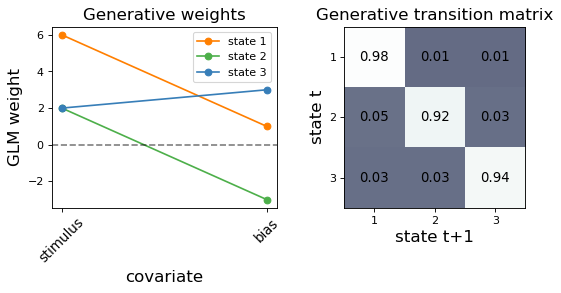

In [5]:
# Plot generative parameters:
fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
for k in range(num_states):
    plt.plot(range(input_dim), gen_weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))
plt.yticks(fontsize=10)
plt.ylabel("GLM weight", fontsize=15)
plt.xlabel("covariate", fontsize=15)
plt.xticks([0, 1], ['stimulus', 'bias'], fontsize=12, rotation=45)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
plt.legend()
plt.title("Generative weights", fontsize = 15)

plt.subplot(1, 2, 2)
gen_trans_mat = np.exp(gen_log_trans_mat)[0]
plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
for i in range(gen_trans_mat.shape[0]):
    for j in range(gen_trans_mat.shape[1]):
        text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                        color="k", fontsize=12)
plt.xlim(-0.5, num_states - 0.5)
plt.xticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.yticks(range(0, num_states), ('1', '2', '3'), fontsize=10)
plt.ylim(num_states - 0.5, -0.5)
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("Generative transition matrix", fontsize = 15)

### External input sequences

Simulate an example set of ecternal inputs fro each trial in a session. We will create an array of size `(num_sess x num_trials_per_sess x num_covariates)`. For each trial in a session we weill include the stimulus presented to the animal at that trial, as well as a  '1' as the second covariate (so as the capture the animals innate bias for one of the two options available to it).

In [13]:
def get_trials(session_id):
    # generate the number of trials in one session
    selected_trials=data.loc[data['session_number']==session_id,'trial_id'].to_numpy()
    return selected_trials

def get_trial_size(session_id):
    selected_trials=get_trials(session_id)
    selected_trials_diff=np.diff(selected_trials)
    trial_size_accum=np.where(selected_trials_diff !=1)[0]
    trial_size=np.diff(trial_size_accum)
    if len(trial_size)==0:
        return []
    else:
        trial_size=np.insert(trial_size,0,trial_size_accum[0])
        return trial_size

def get_trial_num(session_id):
    trial_size=get_trial_size(session_id)
    return len(trial_size)

# calculate number of sessions
sessions=data['session_number'].to_numpy()
num_sess=np.unique(sessions)
print(f"number of sessions: {len(num_sess)}")

# calculate number of trials per sessions
for sess in num_sess:
    num_trials_per_sess=get_trial_num(session_id=sess)
    print(f"session {sess} has {num_trials_per_sess} trials")

# calculate inputs

number of sessions: 13
session 1 has 2044 trials
session 2 has 140 trials
session 3 has 34 trials
session 4 has 14 trials
session 5 has 6 trials
session 6 has 6 trials
session 7 has 0 trials
session 8 has 0 trials
session 9 has 0 trials
session 10 has 0 trials
session 11 has 0 trials
session 12 has 0 trials
session 13 has 0 trials
